In [234]:
# Use PyTorch to build neural networkabs
# Inspired by pytorch workshop conducted in MSBD 5001 course

# Import required packages
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import cv2
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToPILImage
from torch.nn.init import kaiming_uniform_
import matplotlib.pyplot as plt

In [235]:
# Import the yield data as pandas data frame (Note this is saved as a csv file in base working directory)
file_path = os.path.join(os.getcwd()) + '/'
file_name = 'Crop_Yields.csv'
yield_data = pd.read_csv(file_path + file_name)

In [236]:
# Create class to load dataset

class CustomImageDataset():
    def __init__(self, hist_dir, crop_yield_table, transform=None, target_transform=None):  
        self.hist_dir = hist_dir # References the directory for each given country where the data is stored
        self.transform = transform
        self.target_transform = target_transform
        # load the files 
        filenames = [] # For every year, yields a numpy array of dimension 576 x 29
        crop_yields = []
        for filename in os.listdir(hist_dir):
            filenames.append(filename)
            crop_yields.append(crop_yield_table[crop_yield_table.Year == int(filename[-8:-4])]['Cereal Yield'].values[0])
        self.filenames = filenames
        self.crop_yields =crop_yields
        
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        hist_dir = os.path.join(self.hist_dir, self.filenames[idx])
        #hist = torch.from_numpy(np.load(hist_dir)).float()
        hist = np.load(hist_dir)
        # hist_3 = img2 = cv2.merge((hist,hist,hist))
        
        # Turn into 3 channel array (triplicate of single layer) --> to function with known model architectures
        hist_3 = np.zeros( ( np.array(hist).shape[0], np.array(hist).shape[1], 3 ) )
        hist_3[:,:,0] = hist # same value in each channel
        hist_3[:,:,1] = hist
        hist_3[:,:,2] = hist
        
        if self.transform:
            hist = self.transform(hist_3).float()
        crop_yield = torch.from_numpy(self.crop_yields[idx].reshape(-1, 1)).float()
        return hist, crop_yield

In [237]:
from torchvision.transforms import Resize, ToTensor, Compose

# crop_dataset = CustomImageDataset("./kenya", crop_yield_table = yield_data, transform = ToTensor())
crop_dataset = CustomImageDataset("./kenya", crop_yield_table = yield_data, transform = Compose([ToTensor(), Resize((224,224))]))

# print(dataset.filenames)
# print(dataset.crop_yields)
# dataset[3]

In [238]:
crop_dataset[3] # Shows for a given tensor which consists of a pair of 1) array of binned histogram data; and 2) yield output

(tensor([[[0.0517, 0.0517, 0.0517,  ..., 0.0000, 0.0000, 0.0000],
          [0.1833, 0.1833, 0.1833,  ..., 0.5211, 0.5211, 0.5211],
          [0.0794, 0.0794, 0.0794,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0338, 0.0338, 0.0338],
          [0.3571, 0.3571, 0.3571,  ..., 0.1880, 0.1880, 0.1880],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0517, 0.0517, 0.0517,  ..., 0.0000, 0.0000, 0.0000],
          [0.1833, 0.1833, 0.1833,  ..., 0.5211, 0.5211, 0.5211],
          [0.0794, 0.0794, 0.0794,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0338, 0.0338, 0.0338],
          [0.3571, 0.3571, 0.3571,  ..., 0.1880, 0.1880, 0.1880],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0517, 0.0517, 0.0517,  ..., 0.0000, 0.0000, 0.0000],
          [0.1833, 0.1833, 0.1833,  ..., 0.5211, 0.5211, 0.5211],
          [0.0794, 0.0794, 0.0794,  ...,

In [239]:
crop_dataset[3][0].dtype

torch.float32

In [240]:
crop_dataset[3][1].dtype

torch.float32

In [241]:
crop_dataset[3][0].shape # For each binned histogram data, consists of 576 observations across 29 dimensions

torch.Size([3, 224, 224])

type of the image:  <class 'torch.Tensor'>
Yield: tensor([[1.2400]])


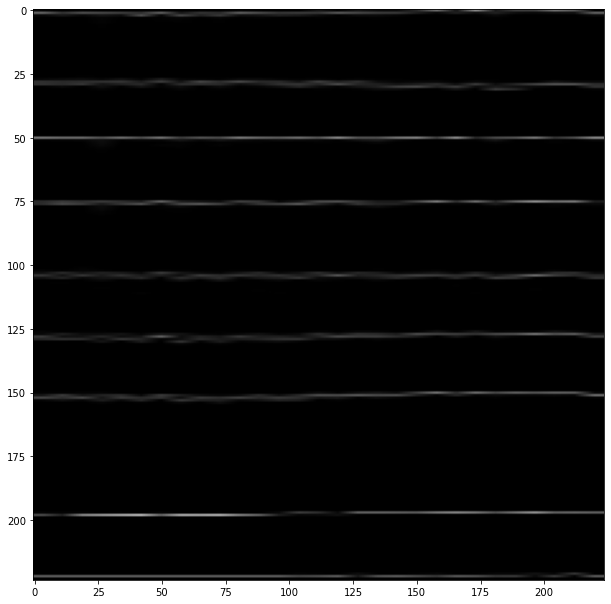

In [242]:
# Plot data for one sample pair
raw_image, crop_yield = crop_dataset[0]
figure = plt.figure()
figure.set_size_inches(18.5, 10.5)

print("type of the image: ", type(raw_image))

if type(raw_image) == torch.Tensor:
    plt.imshow(ToPILImage()(raw_image))
else:
    plt.imshow(raw_image)
    
print(f"Yield: {crop_yield}")

In [243]:
raw_image.shape

torch.Size([3, 224, 224])

In [244]:
# Now moving on to the machine learning model

In [245]:
dataloader = DataLoader(crop_dataset, batch_size=1, shuffle=False)

In [246]:
for feature, label in dataloader:
    print(f"Feature batch shape: {feature.size()}")
    print(label)
    print(f"Feature data type: {feature.dtype}")
    print(f"Label data type: {label.dtype}")

Feature batch shape: torch.Size([1, 3, 224, 224])
tensor([[[1.2400]]])
Feature data type: torch.float32
Label data type: torch.float32
Feature batch shape: torch.Size([1, 3, 224, 224])
tensor([[[1.7100]]])
Feature data type: torch.float32
Label data type: torch.float32
Feature batch shape: torch.Size([1, 3, 224, 224])
tensor([[[1.5100]]])
Feature data type: torch.float32
Label data type: torch.float32
Feature batch shape: torch.Size([1, 3, 224, 224])
tensor([[[1.7400]]])
Feature data type: torch.float32
Label data type: torch.float32
Feature batch shape: torch.Size([1, 3, 224, 224])
tensor([[[1.6600]]])
Feature data type: torch.float32
Label data type: torch.float32
Feature batch shape: torch.Size([1, 3, 224, 224])
tensor([[[1.5800]]])
Feature data type: torch.float32
Label data type: torch.float32
Feature batch shape: torch.Size([1, 3, 224, 224])
tensor([[[1.7700]]])
Feature data type: torch.float32
Label data type: torch.float32
Feature batch shape: torch.Size([1, 3, 224, 224])
tenso

In [247]:
# Check device used
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [226]:
# Based on https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [227]:
# Based on https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=1):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input)
        input = self.fc(input)

        return input

In [ ]:
# Don't use pre-trained
model = ResNet18(in_channels = 3, resblock = ResBlock).to(device)
trainloader = dataloader # train_dataloader_resnet
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
# optimizer = torch.optim.Adam
print(model)
# print(model(crop_dataset[3].to(device)))

In [249]:
# Potentially enhanced with transfer learning...?
# resnet_model = models.resnet18(pretrained=True).to(device)
# trainloader = dataloader # train_dataloader_resnet
# loss_fn = torch.nn.MSELoss()
# optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
# # optimizer = torch.optim.Adam
# print(model)
# # print(model(crop_dataset[3].to(device)))

ResNet18(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [232]:
# Train model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    correct, train_loss = 0, 0 
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        print(f"Actual {y}")
        print(f"Predicted {pred}")

        # Backpropagation
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step() 
    train_loss /= num_batches
    return train_loss 

In [233]:
epochs = 500
for t in range(epochs):
    train_loss = train(trainloader, model, loss_fn, optimizer)
    # test_loss, test_acc = test(testloader, model, loss_fn)
    if t%1 == 0:
        print(f"Epoch {t}:")
        print(f"Avg loss: {train_loss:>8f}")
print("Done!")

C:\Users\Paul\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([0.6077], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.4318], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([2.1801], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([0.7887], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([2.0386], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.4322], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([2.3451], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([0.7019], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.9274], device='cuda:0', grad_fn

Predicted tensor([1.6927], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5151], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.6829], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4698], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6670], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7872], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 7:
Avg loss: 0.002705
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2146], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7333], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4911], device='cuda:0', grad_fn=<AddBackward0>)


Predicted tensor([1.6250], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.6214], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 14:
Avg loss: 0.012960
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.4254], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6858], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4209], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7482], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.8458], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.4023], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7710], device='cuda:0', grad_fn=<AddBackward0>)

Predicted tensor([1.7465], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5305], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.7679], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.5739], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.5934], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.4983], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8133], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 22:
Avg loss: 0.016154
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.3547], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6122], device='cuda:0', grad_fn=<AddBackward0>)

Predicted tensor([1.5423], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.8411], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.2555], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.7509], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.6990], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 29:
Avg loss: 0.011094
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.3521], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7043], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.3672], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.8824], device='cuda:0', grad_fn=<AddBackward0>)

Predicted tensor([1.4371], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.5364], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.9209], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 36:
Avg loss: 0.008943
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1054], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.8267], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4601], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.6740], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.7677], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5122], device='cuda:0', grad_fn=<AddBackward0>)

Predicted tensor([1.7803], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 43:
Avg loss: 0.010276
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.3508], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6274], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.6394], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.6224], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6951], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5689], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.8035], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.2950], device='cuda:0', grad_fn=<AddBackward0>)

Predicted tensor([1.6660], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.6340], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.5907], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.4558], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.9040], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 51:
Avg loss: 0.018450
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2599], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6922], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5419], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.6310], device='cuda:0', grad_fn=<AddBackward0>)

Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.3096], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6532], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5559], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7011], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6198], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6263], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7862], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.2946], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.7494], device='cuda:0', grad_fn

Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7968], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3581], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6215], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8553], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 66:
Avg loss: 0.005839
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1910], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.8176], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4103], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.6984], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.79

Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2287], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.5890], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.6795], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.6444], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.7233], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5215], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.8293], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3126], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6745], device='cuda:0', grad_fn

Predicted tensor([1.6014], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.6056], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.5986], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.8031], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5060], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7914], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3393], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.7229], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7090], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 81:
Avg loss: 0.014252

Predicted tensor([1.7333], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4583], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.5750], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8250], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 88:
Avg loss: 0.002649
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2793], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6602], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5659], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.6971], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6540], device='cuda:0', grad_fn=<AddBackward0>)

Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.7011], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.6400], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 95:
Avg loss: 0.019111
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.4553], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.4585], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5823], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7798], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5116], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6920], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.61

Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8149], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 102:
Avg loss: 0.001782
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2333], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6812], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5252], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7744], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6550], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5157], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.8183], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4

Predicted tensor([1.7620], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4852], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.6856], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.7231], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5272], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.8448], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.2892], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.7240], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.6931], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 110:
Avg loss: 0.00494

Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7145], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3635], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.7127], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7703], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 117:
Avg loss: 0.002839
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2034], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7381], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5099], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7821], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5

Predicted tensor([1.1917], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7920], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.3597], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.8876], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5648], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6037], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7519], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4670], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.5250], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], 

Predicted tensor([1.7743], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6672], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5695], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7217], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4770], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6085], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7460], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 132:
Avg loss: 0.004774
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.3232], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6561], device='cuda:0', grad_fn=<AddBackward0>

Predicted tensor([1.7242], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7018], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 139:
Avg loss: 0.004135
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.3422], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6463], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5368], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7855], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5682], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6504], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7289], device='cuda:0', grad_fn=<AddBackward0>

Predicted tensor([1.2497], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7234], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4706], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.8271], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5516], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6680], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7003], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4450], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.5781], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], 

Predicted tensor([1.2955], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.8959], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5310], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5916], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7061], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.8958], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.3295], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.9488], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 154:
Avg loss: 0.047317
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.3473], device='cuda:0', grad_fn=<AddBackward0>

Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5567], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7667], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3954], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6285], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8050], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 161:
Avg loss: 0.000141
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2418], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7109], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5026], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7

Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1819], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7629], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5590], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.5933], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.7759], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.4773], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.8974], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.2591], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.7594], device='cuda:0', grad_fn

Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.7097], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5622], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7641], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3794], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6546], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7783], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 176:
Avg loss: 0.001390
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2377], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7307], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4

Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7311], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 183:
Avg loss: 0.006555
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.3067], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6794], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4678], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.8622], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5012], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.7370], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.6354], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4

Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4780], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.8056], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5565], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6789], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7049], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4251], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.5969], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8464], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 191:
Avg loss: 0.003488
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2

Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5168], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.7018], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.6643], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4817], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.5433], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8822], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 198:
Avg loss: 0.008936
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1915], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7383], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5

Predicted tensor([1.8711], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 205:
Avg loss: 0.004795
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2056], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7062], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5545], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.6958], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6622], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5851], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7881], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3269], device='cuda:0', grad_fn=<AddBackward0>

Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6635], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5886], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7943], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.2906], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.7392], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7155], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 213:
Avg loss: 0.004042
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.3158], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7004], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4

Predicted tensor([1.3223], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.7141], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7371], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 220:
Avg loss: 0.002480
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2785], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7316], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4282], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.8424], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5845], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6148], device='cuda:0', grad_fn=<AddBackward0>

Predicted tensor([1.5056], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7725], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6346], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5670], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.8041], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3612], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6187], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8438], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 228:
Avg loss: 0.000852
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1769], device='cuda:0', grad_fn=<AddBackward0>

Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5883], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5987], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7863], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3599], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6164], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8505], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 235:
Avg loss: 0.002519
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1761], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7936], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4

Predicted tensor([1.6245], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8214], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 242:
Avg loss: 0.004079
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1858], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7662], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4787], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7554], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6655], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5246], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.8480], device='cuda:0', grad_fn=<AddBackward0>

Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7566], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4769], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7395], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6932], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5105], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.8492], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3277], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6587], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7578], device='cuda:0', grad_fn

Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5445], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.8267], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3408], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6722], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7397], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 257:
Avg loss: 0.003323
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.3231], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6351], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5877], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.6

Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6339], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7882], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 264:
Avg loss: 0.002137
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.3037], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6308], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5888], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.6785], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6973], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5751], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7

Predicted tensor([1.7509], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 271:
Avg loss: 0.003765
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.3435], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.5931], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.6146], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.6752], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6865], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5986], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7288], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3943], device='cuda:0', grad_fn=<AddBackward0>

Predicted tensor([1.3101], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.5910], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5755], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7187], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6471], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5930], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7801], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3290], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6900], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], 

Predicted tensor([1.7702], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3409], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6762], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7998], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 286:
Avg loss: 0.001785
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2057], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7803], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4210], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.8173], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6005], device='cuda:0', grad_fn=<AddBackward0>

Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8045], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 293:
Avg loss: 0.002025
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1939], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7855], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4280], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.8091], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6087], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6170], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7352], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4

Predicted tensor([1.7764], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6185], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6510], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.6731], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.5019], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.5283], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8520], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 301:
Avg loss: 0.006151
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2830], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6287], device='cuda:0', grad_fn=<AddBackward0>

Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7911], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 308:
Avg loss: 0.000844
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.3057], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6416], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5428], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7570], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6221], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6130], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7500], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3

Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7100], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6528], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6216], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7243], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3998], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6342], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8150], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 316:
Avg loss: 0.001904
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2073], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7

Predicted tensor([1.6928], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5615], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7792], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3660], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6291], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8529], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 323:
Avg loss: 0.002737
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1436], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7976], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4463], device='cuda:0', grad_fn=<AddBackward0>

Predicted tensor([1.8809], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 330:
Avg loss: 0.002044
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1483], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7644], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4872], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7226], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6977], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5495], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7591], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4580], device='cuda:0', grad_fn=<AddBackward0>

Predicted tensor([1.4787], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7364], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6941], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5471], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7681], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4440], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.5413], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8559], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 338:
Avg loss: 0.002580
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2736], device='cuda:0', grad_fn=<AddBackward0>

Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4167], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.5138], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8891], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 345:
Avg loss: 0.005918
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2432], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6648], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.6053], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.6118], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.7525], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5

Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2729], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7054], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5142], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7152], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.7084], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5264], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7930], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3952], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.5968], device='cuda:0', grad_fn

Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7124], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6930], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5392], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.8063], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3574], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6298], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8284], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 360:
Avg loss: 0.001284
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1959], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7

Predicted tensor([1.6757], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5353], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.8433], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.2969], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6681], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8212], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 367:
Avg loss: 0.003220
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1966], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7678], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4556], device='cuda:0', grad_fn=<AddBackward0>

Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7883], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 374:
Avg loss: 0.001032
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2329], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7250], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4871], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7646], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6538], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5672], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7790], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3

Predicted tensor([1.2791], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7281], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4463], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.8207], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5953], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6063], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7820], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3526], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6491], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], 

Predicted tensor([1.8243], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5728], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6552], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7088], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4195], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6275], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7909], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 389:
Avg loss: 0.002952
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2619], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7169], device='cuda:0', grad_fn=<AddBackward0>

Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7219], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4152], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6171], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8117], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 396:
Avg loss: 0.002083
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2255], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7642], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4609], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7312], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.7

Predicted tensor([1.4593], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.5770], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8311], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 403:
Avg loss: 0.003846
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2454], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7103], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5080], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7312], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6827], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5365], device='cuda:0', grad_fn=<AddBackward0>

Predicted tensor([1.5290], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8911], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 410:
Avg loss: 0.003666
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1963], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7159], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5397], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.6798], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.7140], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5466], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7842], device='cuda:0', grad_fn=<AddBackward0>

Predicted tensor([1.4904], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7435], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6502], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5854], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7786], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3567], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6538], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7967], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 418:
Avg loss: 0.000358
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2463], device='cuda:0', grad_fn=<AddBackward0>

Predicted tensor([1.6056], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7297], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4194], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6391], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7337], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 425:
Avg loss: 0.003550
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.3548], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6238], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5830], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7001], device='cuda:0', grad_fn=<AddBackward0>

Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8108], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 432:
Avg loss: 0.000666
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2727], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6703], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5426], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7243], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6627], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5807], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7723], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3

Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.6931], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6804], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5795], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7699], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3579], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6763], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7466], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 440:
Avg loss: 0.002014
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2813], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7

Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3648], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6301], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.7948], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 447:
Avg loss: 0.002836
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2696], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6845], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5097], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7720], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.5988], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6

Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2572], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7049], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5040], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7605], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6262], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6183], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7372], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4185], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.5868], device='cuda:0', grad_fn

Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6591], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5366], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7456], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6266], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.6306], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7202], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4112], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6143], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8414], device='cuda:0', grad_fn

Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5798], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7499], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4078], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.5974], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8591], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 469:
Avg loss: 0.000907
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1696], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7655], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4844], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7

Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6119], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8476], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 476:
Avg loss: 0.001297
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.1631], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7962], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4558], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7501], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6715], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5782], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7

Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7777], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.4513], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7768], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6495], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5645], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7848], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.3992], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.5986], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8087], device='cuda:0', grad_fn

Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.6347], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5998], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.7550], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.3800]]], device='cuda:0')
Predicted tensor([1.4012], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6300]]], device='cuda:0')
Predicted tensor([1.6108], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8127], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 491:
Avg loss: 0.001068
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2726], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.6558], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5

Predicted tensor([1.5858], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.8100]]], device='cuda:0')
Predicted tensor([1.8424], device='cuda:0', grad_fn=<AddBackward0>)
Epoch 498:
Avg loss: 0.002785
Actual tensor([[[1.2400]]], device='cuda:0')
Predicted tensor([1.2250], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7100]]], device='cuda:0')
Predicted tensor([1.7102], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5100]]], device='cuda:0')
Predicted tensor([1.5258], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7400]]], device='cuda:0')
Predicted tensor([1.7040], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.6600]]], device='cuda:0')
Predicted tensor([1.7064], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.5800]]], device='cuda:0')
Predicted tensor([1.5259], device='cuda:0', grad_fn=<AddBackward0>)
Actual tensor([[[1.7700]]], device='cuda:0')
Predicted tensor([1.8247], device='cuda:0', grad_fn=<AddBackward0>

In [ ]:
# Other model architectures

In [ ]:

# class ConvNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.network = nn.Sequential(
            
#             nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
#             nn.ReLU(),
#             nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
        
#             nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
            
#             nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
            
#             nn.Flatten(),
#             nn.Linear(82944,1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512,1)
#         )
    
#     def forward(self, xb):
#         return self.network(xb)

In [ ]:
# # Basic Neural Network as outlined in lecture notes
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.flatten = nn.Flatten()
#         #self.linear1 = nn.Linear(28*28, 512)
#         #self.linear2 = nn.Linear(512, 512)
#         #self.linear3 = nn.Linear(512, 10)
#         #self.relu = nn.ReLU()
        
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(28*28, 512),
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 1),
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         #x = self.linear1(x)
#         #x = self.relu(x)
#         #x = self.linear2(x)
#         #x = self.relu(x)
#         #logits = self.linear3(x)
#         logits = self.linear_relu_stack(x)
#         return logits

In [ ]:

# # Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using {device} device")

    
# # Define model
# class ConvNN(nn.Module):
#     def __init__(self):
#         super(ConvNN, self).__init__()
#         self.conv_stack = nn.Sequential(
#             nn.Conv2d(3,6,5),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(6,12,5),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Flatten(),
#             nn.ReLU(),
#             nn.Linear(192, 512),
#             nn.ReLU(),
#             nn.Linear(512, 3)
#         )

#     def forward(self, x):
#         logits = self.conv_stack(x)
#         return logits
    

# print(conv_model)